In [10]:
include("carlin.jl")

kronecker_powers (generic function with 1 method)

## Theory (1 dimension)

To simplify the presentation we consider the scalar Logistic equation first.

Starting with a nonlinear ODE, we construct a linear ODE in higher dimension.

- The abstraction is exact if the linear system has *infinite* dimensions.
    
- The abstraction is approximate if the linear system is *truncated* to order $N$.

This method is known as Carleman linearization [1].

- [1] Explicit Error Bounds for Carleman Linearization: https://arxiv.org/abs/1711.02552

- [2] Efficient quantum algorithm for dissipative nonlinear differential equations: https://arxiv.org/pdf/2011.03185.pdf

Start with the scalar ODE

$$
x'(t) = ax(t) + bx^2(t), \qquad x(0) = x_0
$$

Introduce auxiliary variables

$y_1 = x$, $y_2 = x^2$, $y_3 = x^3$, $y_4 = x^4$

$y_1' = x' = ax + bx^2 = ay_1 + by_2$

$$
y_2' = 2x' x = 2(ax + bx^2)x = 2(ax^2 + bx^3) = 2ay_2 + 2by_3
$$

$$
y_3' = 3x^2 x' = 3(ax^3 + bx^4) = 3ay_3 + 3by_4
$$

$$
y_4' = 4ay_4 + 4by_5
$$

Note that the structure of the equations is $y'_i = iay_i + iby_{i+1}$ for all $y \geq 1$. Therefore, the nonlinear ODE is (formally) equivalent to an infinite-dimensional linear ODE.

Let's now pick a truncation order $N$ and build a finite-dimensional linear ODE.

Truncation with order $N = 4$

$$
\hat{y}' = \begin{pmatrix}
    a & b & 0 & 0 \\
    0 & 2a & 2b & 0 \\
    0 & 0 & 3a & 3b \\
    0 & 0 & 0 & 4a \\
    \end{pmatrix} \hat{y},\qquad \hat{y}(0) = (x_0, x_0^2, x_0^3, x_0^4)
$$

In [2]:
const IA = IntervalArithmetic

IntervalArithmetic

In [4]:
x0 = 0.79 .. 0.81

[0.789999, 0.810001]

In [5]:
x0^2

[0.624099, 0.656101]

In [6]:
x0^3

[0.493038, 0.531442]

In [9]:
kronecker_powers(x0, 10)

10-element Array{IntervalArithmetic.Interval{Float64},1}:
 [0.789999, 0.810001]
 [0.624099, 0.656101]
 [0.493038, 0.531442]
 [0.3895, 0.430468]
 [0.307705, 0.348679]
 [0.243087, 0.28243]
 [0.192039, 0.228768]
 [0.15171, 0.185303]
 [0.119851, 0.150095]
 [0.0946827, 0.121577]

This raises the following question: **how do the solutions of the original ODE compare to the solution of the truncated system?**

## Example (logistic differential equation)

Consider the [Logistic differential equation](https://en.wikipedia.org/wiki/Logistic_equation).

$$
\dfrac{du}{dt} = ru(1 - u/K)
$$

- simple model used for various growth scenarios. has analytic solution.

- $r > 0$ controls the initial rate of exponential growth, and $K > 0$ is the asymptotic equilibrium

- move our frame of reference to the asymptotic equilibrium, $v := K - u$ then we obtain

$$
\dfrac{dv}{dt} = -rv + \frac{r}{K}v^2
$$

- let $a = -r$, $b = r/K$

- to choose numerical values that satisfy the spectral absissa criterion, we have that $R < 1$ if and only if $R = |v(0)| (r/K) / (r) < 1$ that is, $|v(0)| < K$

In [13]:
a = -1.0 # r = 1
b = 1.0  # K = 1
x0 = 0.8 # x0 = v(0) = |v(0)| = 0.8 < K = 1

A = [a  b   0   0;
     0  2a 2b   0;
     0  0  3a  3b;
     0  0   0  4a];

r = -a
K = r / b
F1 = hcat(-r)
F2 = hcat(r/K)

1×1 Array{Float64,2}:
 1.0

## Error bounds

In [17]:
N = 4 # truncation order
y0 = [x0^i for i in 1:N]

# power series
e1 = error_bound_pseries(y0, F1, F2, N=N)

# spectral absissa
e2 = error_bound_specabs(y0, F1, F2, N=N);

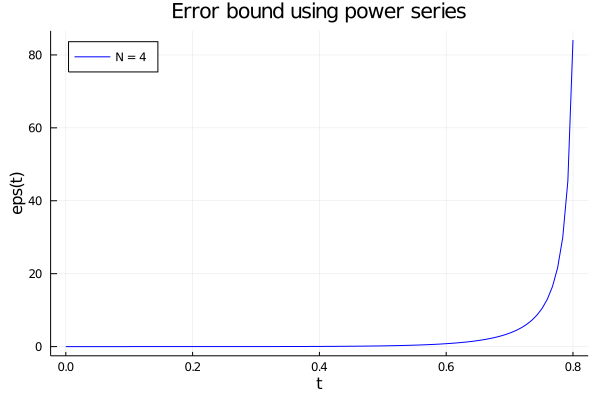

In [27]:
using Plots

dom = range(0, 0.8, length=100)
plot(dom, e1.(dom), lab="N = $N", c=:blue, legend=:topleft, title="Error bound using power series", xlab="t", ylab="eps(t)")

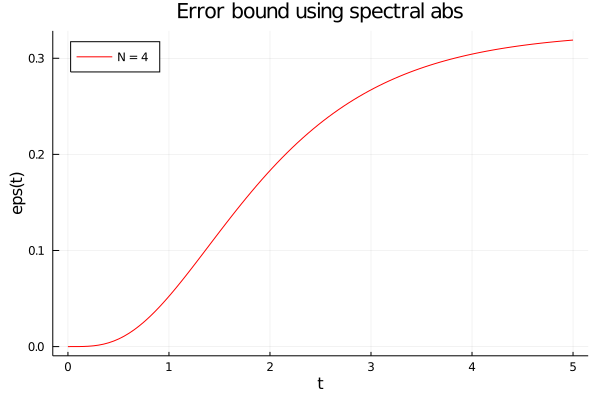

In [26]:
dom = range(0, 5.0, length=100)
plot(dom, e2.(dom), lab="N = $N", c=:red, legend=:topleft, title="Error bound using spectral abs", xlab="t", ylab="eps(t)")

### Interpretation

The error bound using the spectral abs. from https://arxiv.org/pdf/2011.03185.pdf gives a much better error bound under some assumptions.

- let $R = \dfrac{\Vert u_0 \Vert \Vert F_2 \Vert}{\vert Re(\lambda_1)\vert}$

- we require that $Re(\lambda_n) \leq \cdots \leq Re(\lambda_1) < 0$

- $F_1$ is diagonalizable

- Problems with linear dissipation, $Re(\lambda_1) < 0$ and weak nonlinearity in the sense that

$$
\Vert u_0 \Vert \Vert F_1 \Vert < \vert Re(\lambda_1) \vert,
$$
ie. $R < 1$

Given the asssumptions on $R < 1$ the error bound converges for all $t \geq 0$.

$$
\Vert \varepsilon(t) \Vert = \Vert x_0\Vert R^N (1 - e^{Re(\lambda_1) t})^N
$$
where $R = \dfrac{\Vert x_0 \Vert \Vert F_2 \Vert}{\vert Re(\lambda_1)\vert} $

- Condition $Re(\lambda_1) < 0$ implies $a < 0$

$$
R = \dfrac{\Vert x_0 \Vert \Vert F_2 \Vert}{\vert Re(\lambda_1)\vert} = \dfrac{\vert x_0 \vert \vert b \vert }{\vert a \vert} < 1
$$

Implies $\vert x_0 \vert < \vert a \vert / \vert b \vert$

On the contrary the error bound using the power series summation method is more general (applies to systems whose spectral absissa is nonnegative) but the error bound only holds for a certain time horizon $0 < t < T^*$.

## Flowpipe computation

if $x(t)$ denotes the *exact* solution and $\hat{x}(t)$ denotes the solution of the truncated linear system, we know that

$$
\Vert x(t) - \hat{x}(t) \Vert \leq \varepsilon(t) 
$$

In [28]:
A

4×4 Array{Float64,2}:
 -1.0   1.0   0.0   0.0
  0.0  -2.0   2.0   0.0
  0.0   0.0  -3.0   3.0
  0.0   0.0   0.0  -4.0

In [32]:
N = 4
x0 = IA.Interval(0.8, 0.8)
ŷ0 = kronecker_powers(x0, N)

prob = @ivp(ŷ' = Aŷ, ŷ(0) ∈ ŷ0)

InitialValueProblem{LinearContinuousSystem{Float64,Array{Float64,2}},Array{IntervalArithmetic.Interval{Float64},1}}(LinearContinuousSystem{Float64,Array{Float64,2}}([-1.0 1.0 0.0 0.0; 0.0 -2.0 2.0 0.0; 0.0 0.0 -3.0 3.0; 0.0 0.0 0.0 -4.0]), IntervalArithmetic.Interval{Float64}[[0.8, 0.800001], [0.64, 0.640001], [0.512, 0.512001], [0.4096, 0.409601]])